In [2]:
import unicodedata
import string
import pandas as pd
import re
import numpy as np

import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

all_letters = string.ascii_letters + " .,;'0123456789"
n_letters = len(all_letters)

all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'0123456789"

Build Category dictionary, category and list of product name, shor description

In [3]:
from elasticsearch import Elasticsearch
client = Elasticsearch("http://172.17.212.35:9200")
resp = client.search(index="retromotion-indexer_development_products",
                     body={"_source":["descriptions","descriptionsSource","nameSource","shortDescriptionSource","categoriesSource"],
                           'size' : 65000,
                           "query": {"match_all": {}}})

In [4]:
df_eng = pd.DataFrame(columns=['name','sdesc','category','catlevel0','catlevel1','catlevel2','catlevel3','catlevel4','catlevel5'])

In [5]:
def cleanStr(text):
   
    # remove numbers
    # no_number_string = re.sub(r'\d+','',lower_string)

    # remove all punctuation except words and space
    # text = re.sub(r'[^\w\s]','', lower_string)

    # clean = re.compile('<.*?>')

    # text = re.sub(clean,'',text)
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' .join(emoticons).replace('-', ''))

    return text


In [6]:
name_en=[]
name_de=[]

sdesc_en=[]
sdesc_de=[]

desc_en=[]
desc_de=[]

cat_en=[]
cat_de=[]

catpath_en=[]
catpath_de=[]

for hit in resp['hits']['hits']:
    list_row =[]
    for name in hit['_source']['nameSource']:
        if (name["language"]=="en"):
            list_row.append(cleanStr(name["value"]))
        else:
            name_de.append(name["value"])
    
    for sdesc in hit['_source']['shortDescriptionSource']:
        if (sdesc["language"]=="en"):
            list_row.append(cleanStr(sdesc["value"]))
        else:
            sdesc_de.append(sdesc["value"])

    # for desc in hit['_source']['descriptionsSource']:
    #     if (desc["language"]=="en"):
    #         desc_en.append(readHtml(desc["value"]))
    #     else:
    #         desc_de.append(desc["value"])
    
    for cats in hit['_source']['categoriesSource']:
        if (cats["language"]=="en"):
            list_row.append(cleanStr(cats["label"]))
        else:
            desc_de.append(cats["label"])

        if (cats["language"]=="en"):
            categories =cats["path"].split('/')
            i =0
            catls=[]
            for category in categories:

                list_row.append(cleanStr(category))
                i= i+1
            
        else:
            catpath_de.append(cats["path"])
    
    # new_row = pd.DataFrame({'name':_name, 'sdesc':_sdesc, 'category':_cat_en }, index=[0])

    # pd.concat([new_row,df_eng.loc[:]]).reset_index(drop=True)

    for i in range (0,9-len(list_row)):
        list_row.append(np.nan)

    df_eng=df_eng.append(pd.Series(list_row, index=df_eng.columns[:len(list_row)],ignore_index=True))
    # df_eng.loc[len(df_eng)] = list_row



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
df_eng.head()

,name,sdesc,category,catlevel0,catlevel1,catlevel2,catlevel3,catlevel4,catlevel5
0,denso dtm82363 thermostat coolant,thermostat coolant,thermostat,sparepart,cooling system,thermostat,NaN,NaN,NaN
1,zf 1043 010 297 automatic transmission,automatic transmission,automatic transmission,sparepart,transmission,automatic transmission,automatic transmission,NaN,NaN
2,zf 1060 040 003 automatic transmission,automatic transmission,automatic transmission,sparepart,transmission,automatic transmission,automatic transmission,NaN,NaN
3,vaico v10 0131 camshaft,camshaft,camshaft,sparepart,engine,engine timing,camshaft,NaN,NaN
4,vaico v26 0302 track control arm,track control arm,track control arm,sparepart,powertrain suspension,wheel suspension,track control arm,NaN,NaN


In [ ]:
df_category = df_eng.groupby('category')

In [ ]:
df_category.get_group('automatic transmission')['name']



1        zf 1043 010 297 automatic transmission
2        zf 1060 040 003 automatic transmission
19       zf 1043 010 562 automatic transmission
20       zf 1050 012 014 automatic transmission
37       zf 1043 000 224 automatic transmission
                          ...                  
22275    zf 1043 010 644 automatic transmission
22276    zf 1043 010 670 automatic transmission
22310    zf 1060 030 049 automatic transmission
22320    zf 1043 010 373 automatic transmission
22321    zf 1050 020 026 automatic transmission
Name: name, Length: 492, dtype: object

In [ ]:
# extract keys from groups
keys =df_category.groups.keys() 
# for i in keys:
#     print(category.get_group(i))
#     print('\n')

    # Display result

all_categories=list(keys)

print (all_categories)

['accelerator cable', 'accessory kit', 'actuator', 'adapter cable', 'adaptor', 'additional water pump', 'adjust screw', 'aerial', 'aerial head', 'air 47 electric horn', 'air conditioning', 'air filter', 'air horn', 'air mass sensor', 'air pressure sensor', 'air quality sensor', 'air supply', 'alternator', 'alternator freewheel clutch', 'alternator regulator', 'anti friction bearing', 'antifreeze', 'assortment box', 'automatic circuit breaker', 'automatic transmission', 'automatic transmission oil', 'auxiliary indicator', 'ball head', 'ball joint', 'base', 'battery post clamp', 'bearing', 'bearing bush', 'bellow', 'bellow set', 'belt drive', 'belt pulley', 'belt pulley set', 'belt tensioner', 'big end bearings', 'bolt', 'bonnet cable', 'bonnet lock', 'boost pressure control valve', 'bracket', 'brake caliper', 'brake caliper axle kit', 'brake disc', 'brake drum', 'brake hose', 'brake light switch', 'brake master cylinder', 'brake pad set', 'brake set', 'brake shoe set', 'brake system', '

#### Turning product Names into Tensors
        	    
Represent each name in one-hot encoded form (1 for the position of the letter, 0 elsewhere)

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.
That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [ ]:
import torch

In [ ]:
def letterToTensor(letter):
    
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    
    return tensor

In [ ]:
print(letterToTensor('a'))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [1]:
p_tensor = nameToTensor('denso')

p_tensor.size()

NameError: name 'nameToTensor' is not defined

In [22]:
p_tensor

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [16]:
n_hidden = 256
n_category = len(category)

rnn = RNN(n_letters, n_hidden, n_category)

In [17]:
inp = letterToTensor('C')

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(inp, hidden)

print('output size =', output.size())
print('next_hidden size =', next_hidden.size())

output size = torch.Size([1, 17])
next_hidden size = torch.Size([1, 256])


In [ ]:
inp = nameToTensor('denso dtm82363 thermostat coolant')

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(inp[0], hidden)

In [ ]:
print(next_hidden)

In [19]:
print(output)

tensor([[-2.8616, -2.7816, -2.8194, -2.8661, -2.8955, -2.8495, -2.8488, -2.8467,
         -2.9117, -2.7902, -2.8215, -2.7953, -2.8066, -2.7708, -2.8125, -2.8050,
         -2.8961]], grad_fn=<LogSoftmaxBackward0>)


In [20]:
def categoryFromOutput(output):
    
    _, top_i = output.topk(1)
    
    cat_i = top_i[0].item()
    
    return all_categories[cat_i], cat_i

In [21]:
print(categoryFromOutput(output))

('air mass sensor', 13)


#### get training samples category and names

In [22]:
import random

def randomTrainingExample():
    
    random_cat_index = random.randint(0, n_category - 1)
    randcategory = all_categories[random_cat_index]
    
    # get feature name from the category
    random_feature_names = df_category.get_group(randcategory)['name']
    
    name = random_feature_names.array[random.randint(0, len(random_feature_names) - 1)]
    
    category_tensor = torch.tensor([all_categories.index(randcategory)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    
    return randcategory, name, category_tensor, name_tensor

In [23]:
for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    
    print('category =', category, ', name =', name)

category = accessory kit , name = mapco 9167 accessory kit brake shoes
category = air 47 electric horn , name = vemo v30 77 0150 1 air electric horn
category = adjust screw , name = adjust screw headlight
category = accelerator cable , name = vaico v24 0376 accelerator cable
category = air conditioning , name = mahle original ad 114 000s dryer air conditioning
category = aerial head , name = vemo v25 22 0001 aerial head
category = air 47 electric horn , name = vemo v30 77 0150 1 air electric horn
category = air conditioning , name = mahle original acp 1234 000p compressor air conditioning
category = accessory kit , name = accessory kit disc brake pads
category = aerial , name = vemo v10 22 0001 aerial


#### Training the Network

In [24]:
criterion = nn.NLLLoss()
learning_rate = 0.005 

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
- Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [ ]:
def train(category_tensor, name_tensor):
    
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [26]:
n_iters = 200000

current_loss = 0
all_losses = []

In [27]:
for epoch in range(1, n_iters + 1):
    
    category, name, category_tensor, name_tensor = randomTrainingExample()
    
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    if epoch % 5000 == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        
        print('%d %d%% %.4f %s / %s %s' % (epoch, 
                                           epoch / n_iters * 100,
                                           loss,
                                           name, 
                                           guess, 
                                           correct))

    if epoch % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

/tmp/ipykernel_2627/665512115.py:14: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(-learning_rate, p.grad.data)


5000 2% nan vemo v10 77 0917 1 air electric horn / air conditioning ✗ (air 47 electric horn)
10000 5% nan hella 8ja 005 952 041 adapter cable towbar socket / air conditioning ✗ (adapter cable)
15000 7% nan mahle original acp 873 000p compressor air conditioning / air conditioning ✓
20000 10% nan aks dasis 850811n compressor air conditioning / air conditioning ✓
25000 12% nan adaptor cigarette lighter / air conditioning ✗ (adaptor)
30000 15% nan ngk 92710 air mass sensor / air conditioning ✗ (air mass sensor)
35000 17% nan vemo v70 16 0002 additional water pump / air conditioning ✗ (additional water pump)
40000 20% nan ngk 93373 air mass sensor / air conditioning ✗ (air mass sensor)
45000 22% nan denso dat23001 actuator air conditioning / air conditioning ✗ (actuator)
50000 25% nan vemo v52 72 0135 sensor intake manifold pressure / air conditioning ✗ (air pressure sensor)
55000 27% nan adaptor cigarette lighter / air conditioning ✗ (adaptor)
60000 30% nan adjust screw headlight / air co

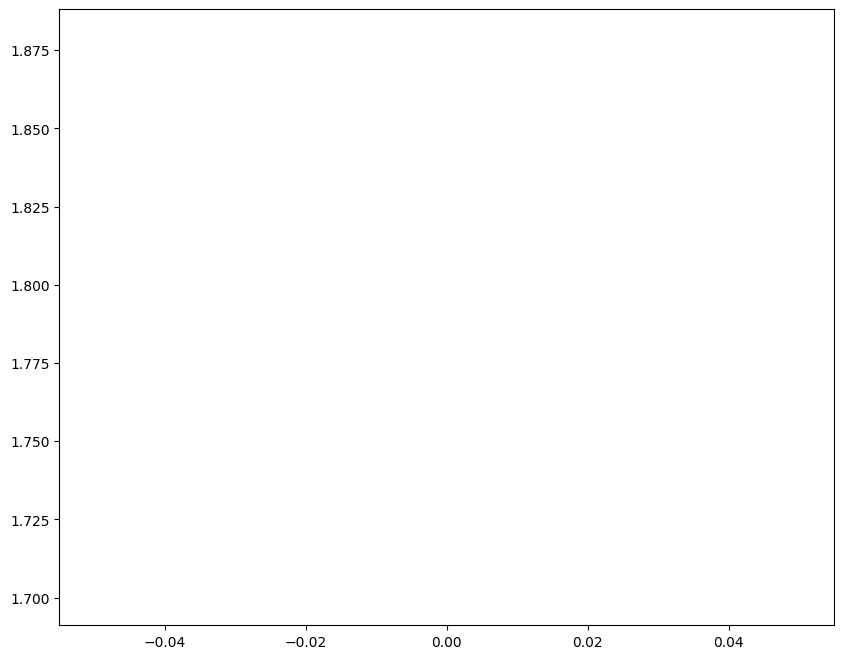

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(all_losses)
plt.show()

In [69]:
n_predictions = 3

In [71]:
input_name = 'suspension kit'

In [72]:
with torch.no_grad():
    
    name_tensor = nameToTensor(input_name)
    
    hidden = rnn.initHidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    topv, topi = output.topk(n_predictions, 1, True)

    for i in range(n_predictions):
        
        value = topv[0][i].item()
        cat_i = topi[0][i].item()
        
        print('(%.2f) %s' % (value, all_categories[cat_i]))

(nan) track control arm
(nan) tensioner pulley
(nan) thermostat
